In [25]:
import csv
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import re
import os
import pickle

file_path = 'cacna1a_wt_2597v_gpu_residue.rounded.csv'
# os.chdir('Cosine Branch')
!ls

3200.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


cacna1a_wt_2597v_gpu_residue.rounded.csv  setup.sh  test


In [27]:
# Function to compute cosine similarity between two vectors
def compute_cosine_similarity(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

# Function to parse the protein name and position from the row
def parse_protein_and_position(row):
    protein_name = row[-2]
    position_info = row[-1]
    amino_acid = position_info[0]  # First character is the amino acid
    position = int(position_info[1:])  # Rest of the string is the position
    return protein_name, amino_acid, position

# Function to extract the mutation status from the protein name
def extract_mutation_status(protein_name):
    if "|" in protein_name:
        status = protein_name.split('|')[-1]
        return 0 if status == 'nan' else 1
    return 0

# Function to write mutated_rows to a binary file
def write_to_file(mutated_rows, file_index):
    with open(f'mutated_rows_{file_index}.pkl', 'wb') as file:
        pickle.dump(mutated_rows, file)

# Function to read mutated_rows from a binary file
def read_from_file(file_index):
    with open(f'mutated_rows_{file_index}.pkl', 'rb') as file:
        return pickle.load(file)

# Process the CSV file line by line to avoid memory issues
def process_csv_file(file_path):
    wt_rows = []
    mutated_rows = []
    mutated_file_count = 0
    max_mutated_rows_size = 600000  # Threshold to save to a file

    # Open the file and read line by line
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Skip the header row

        # Iterate over each row in the CSV file
        for row in reader:
            # Extract the protein name and position
            protein_name, amino_acid, position = parse_protein_and_position(row)

            # Convert the fractional columns to a numpy array (all columns except the last two)
            vector = np.array(row[:-2], dtype=float)

            # Extract mutation status
            mutation_status = extract_mutation_status(protein_name)

            # If it's a WT (wild-type) protein
            if protein_name.startswith('>WT|'):
                # Store the WT vector by position
                wt_rows.append({'AA': amino_acid, 'Pos': position, 'Vector': vector, 'Status': mutation_status})
            else:
                # Store the mutated row along with position and vector if it corresponds to the mutation
                match = re.search(r'>\w(\d+)(\w)\|', protein_name)
                if match:
                    mutant_name = f"{match.group(2)}{match.group(1)}"  # Extract the position and the new amino acid
                    
                    if mutant_name == row[-1]:
                        mutated_rows.append({'AA': amino_acid, 'Pos': position, 'Vector': vector, 'Status': mutation_status})
                
                # Check if the length of mutated_rows exceeds the threshold
                if len(mutated_rows) >= max_mutated_rows_size:
                    # Write to a binary file and reset the mutated_rows list
                    write_to_file(mutated_rows, mutated_file_count)
                    mutated_file_count += 1
                    mutated_rows = []

    # After the loop, save any remaining mutated_rows to a file
    if mutated_rows:
        write_to_file(mutated_rows, mutated_file_count)
        mutated_file_count += 1

    # List to store results with cosine similarity
    results = []

    # Now process each file of mutated rows
    for i in range(mutated_file_count):
        # Read mutated rows from file
        mutated_rows = read_from_file(i)

        # Compare each mutated row to the WT rows
        for mutated_row in mutated_rows:
            position = mutated_row['Pos']
            mutated_vector = mutated_row['Vector']
            amino_acid = mutated_row['AA']
            status = mutated_row['Status']

            # Find the corresponding WT row by position
            wt_row = next((wt for wt in wt_rows if wt['Pos'] == position), None)

            if wt_row:
                wt_vector = wt_row['Vector']
                wt_amino_acid = wt_row['AA']

                # Compute cosine similarity between WT and mutated vector
                similarity = compute_cosine_similarity(wt_vector, mutated_vector)
                # Store results with position, similarity, WT amino acid, mutation amino acid, and status
                results.append([f"{wt_amino_acid}{position}{amino_acid}", similarity, status])

    # Create a DataFrame to store the results
    result_df = pd.DataFrame(results, columns=['Mutant', 'CosineSim', 'Status'])

    return result_df

# process the embedding file
result_df = process_csv_file(file_path)

# Display the result
print(result_df)


      Mutant  CosineSim  Status
0        A2S   0.830556       1
1        A2V   0.791399       1
2        R3C   0.625089       1
3        R3G   0.705138       1
4        G5V   0.630909       0
...      ...        ...     ...
2588  D2503H   0.629078       0
2589  D2503N   0.674396       0
2590  D2504G   0.743554       0
2591  C2506S   0.703664       0
2592  C2506Y   0.771566       0

[2593 rows x 3 columns]


In [44]:
def Wild_Type_Vectors():
    wt_rows = []
    mutated_rows = []
    mutated_file_count = 0
    max_mutated_rows_size = 600000  # Threshold to save to a file

    # Open the file and read line by line
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Skip the header row

        # Iterate over each row in the CSV file
        for row in reader:
            # Extract the protein name and position
            protein_name, amino_acid, position = parse_protein_and_position(row)

            # Convert the fractional columns to a numpy array (all columns except the last two)
            vector = np.array(row[:-2], dtype=float)

            # Extract mutation status
            mutation_status = extract_mutation_status(protein_name)

            # If it's a WT (wild-type) protein
            if protein_name.startswith('>WT|'):
                # Store the WT vector by position
                wt_rows.append({'AA': amino_acid, 'Pos': position, 'Vector': vector, 'Status': mutation_status})
            else:
                return pd.DataFrame(wt_rows)
            # if the following is an MT, obtain the protien ID to get position, then index the wtv df to get the wtv and compute cosine similarity
            # store it
            # generate new vector: AAStart+ position +AAend, cosine score, label, control(origin)


In [46]:
(Wild_Type_Vectors())

,AA,Pos,Vector,Status
0,M,1,"[0.262, -0.101, 0.069, 0.15, -0.004, 0.139, -0...",0
1,A,2,"[0.217, -0.019, 0.201, 0.262, -0.214, 0.001, -...",0
2,R,3,"[0.007, -0.05, 0.097, 0.164, -0.171, 0.191, -0...",0
3,F,4,"[0.005, 0.064, 0.161, 0.182, 0.021, 0.095, 0.1...",0
4,G,5,"[-0.045, -0.026, 0.18, 0.279, -0.049, 0.158, -...",0
...,...,...,...,...
2501,D,2502,"[-0.053, -0.027, 0.073, 0.308, 0.386, 0.13, -0...",0
2502,D,2503,"[-0.063, -0.064, 0.08, 0.225, 0.319, 0.246, -0...",0
2503,D,2504,"[0.009, -0.058, 0.067, 0.198, 0.179, 0.077, -0...",0
2504,W,2505,"[-0.25, -0.019, -0.108, -0.115, -0.103, -0.005...",0


In [36]:
pos_arr = []
neg_arr = []

for index in range(len(result_df)):
    if result_df['Status'][index] == 0:
        neg_arr.append(result_df['CosineSim'][index])
    else:
        pos_arr.append(result_df['CosineSim'][index])

<Axes: ylabel='Density'>

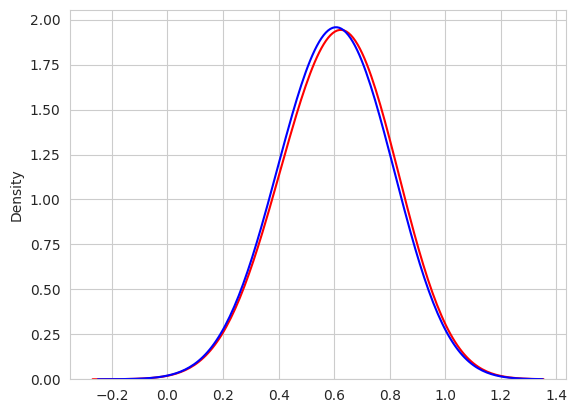

In [30]:
import seaborn as sns
sns.set_style('whitegrid')
sns.kdeplot(np.array(pos_arr), bw_method=1, color='red')
sns.kdeplot(np.array(neg_arr), bw_method=1, color='blue')

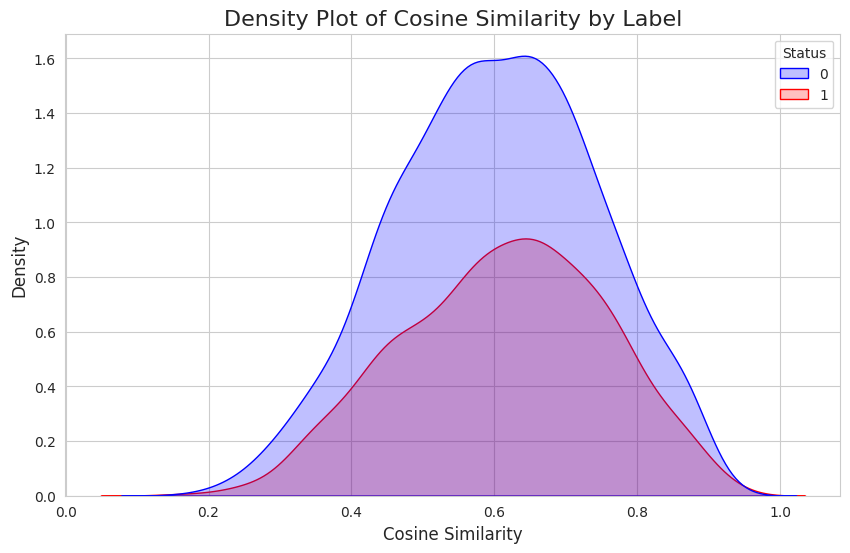

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming result_df is the DataFrame with columns 'Mutant', 'CosineSim', and 'Status'

# Set the plot size
plt.figure(figsize=(10, 6))

# Create the density plot using seaborn with specific colors for Status
sns.kdeplot(data=result_df, x="CosineSim", hue="Status", fill=True, palette={0: "blue", 1: "red"})

# Add titles and labels
plt.title("Density Plot of Cosine Similarity by Label", fontsize=16)
plt.xlabel("Cosine Similarity", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Show the plot
plt.show()


In [38]:
!bsub -Is -q gpu-v100 -W 2:00 -n 8 M 4000 -gpu "num=1" -R "span[hosts=1]"

10117.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Job <4517208> is submitted to queue <gpu-v100>.
<<Waiting for dispatch ...>>
<<Terminated while pending>>
<<Terminated on execution host. Use "bhist -l 4517208" for details>>
